# Introduction

**Human Activity Recognition (HAR)** is a field in computer science that aims to create systems that recognize, classify and take actions based on human action data captured by sensors.

This notebook contains the entire pipeline of a Data Science project that uses labeled data to train a **Machine Learning** system that can extract patterns from the data and generalize to unseen samples. The project consists on capturing frames from the webcam and predict the actions being performed into **4 classes**: 
- Hello signal;
- Thanks signal; 
- I Love You signal;
- Doing nothing;

The pipeline is the following:

* Collection of data to use in the training, validation and testing phases of a Machine Learning system;

    * The data is collected using the webcam to capture frames. They are then passed to a pretrained ML model that extracts **Keypoints** from the body. Read more about this model [here](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/holistic.md).

* Pre processing of the Keypoints captured to create **embeddings** of the frames. These embeddings encode the action being performed and can be processed as a sequence to be classified;

* Creation and training of a **Recurrent Neural Network** using LSTM building blocks, which is capable of processing sequences and extracting patterns of them to perform predictions;

    * The network is modeled with **2 LSTM layers** that receive the sequence and output the last hidden state after the processing phase. Then, **Fully Connected layers** are used to process the output of the RNN and output logits corresponding to the likelihood of the sequence being of one of the 4 classes.

* After training and analysis of the results, predictions are performed on unlabeled data captured on **real time**; 


The project is based on [this YouTube video](https://youtu.be/doDUihpj6ro?si=9nu-WivTaBG_jJ4p).

In [1]:
recover_checkpoints = True
collect_data_points = False

# 1. Imports and Dependencies

In [ ]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install lightning


In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import mediapipe as mp

# 2. Keypoints unsing MediaPipe Holistic

In [3]:
from cv2.typing import MatLike
from typing import Tuple, NamedTuple
from mediapipe.python.solutions.holistic import Holistic, HAND_CONNECTIONS, POSE_CONNECTIONS
from mediapipe.python.solutions.drawing_utils import draw_landmarks, DrawingSpec, BLUE_COLOR, GREEN_COLOR, RED_COLOR, WHITE_COLOR, BLACK_COLOR

In [102]:
# Capture Keypoints from frame
def mediapipe_detection(frame: MatLike, model: Holistic) -> Tuple[MatLike, NamedTuple]:
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [103]:
# Draw Keypoints and connections on the image to be displayed
def draw_landmarks_image(image: MatLike, results: NamedTuple) -> None:
    draw_landmarks(image, results.left_hand_landmarks, HAND_CONNECTIONS)
    draw_landmarks(image, results.right_hand_landmarks, HAND_CONNECTIONS)
    draw_landmarks(image, results.pose_landmarks, POSE_CONNECTIONS)

In [104]:
# Draw Keypoints and connections on the image to be displayed
def draw_styled_landmarks_image(image: MatLike, results: NamedTuple) -> None:
    draw_landmarks(image, results.left_hand_landmarks, HAND_CONNECTIONS,
                   DrawingSpec(color=BLUE_COLOR, thickness=1, circle_radius=1),
                   DrawingSpec(color=BLACK_COLOR, thickness=1, circle_radius=1),
                   )
    draw_landmarks(image, results.right_hand_landmarks, HAND_CONNECTIONS,
                   DrawingSpec(color=BLUE_COLOR, thickness=1, circle_radius=1),
                   DrawingSpec(color=BLACK_COLOR, thickness=1, circle_radius=1),
                   )
    draw_landmarks(image, results.pose_landmarks, POSE_CONNECTIONS,
                   DrawingSpec(color=GREEN_COLOR, thickness=2, circle_radius=2),
                   DrawingSpec(color=WHITE_COLOR, thickness=1, circle_radius=1),
                   )

In [9]:
cap = cv2.VideoCapture(0)
with Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)

        draw_styled_landmarks_image(image, results)

        cv2.imshow("OpenCV Feed", image)

        if cv2.waitKey(10) & 0xFF == ord("q"):
            break

cap.release()
cv2.destroyAllWindows()

# 3. Extracting Keypoints

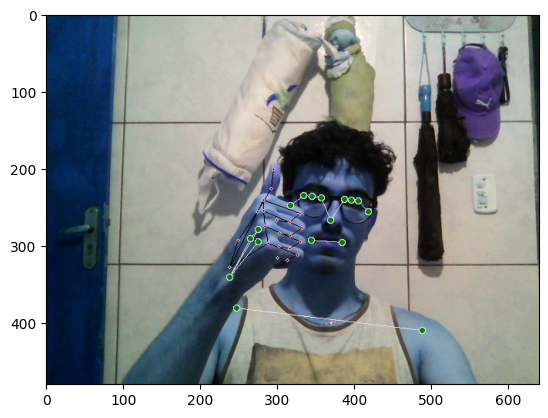

In [10]:
plt.imshow(image)

In [11]:
results.face_landmarks.landmark[0], results.pose_landmarks.landmark[0], results.left_hand_landmarks.landmark[0] 

AttributeError: 'NoneType' object has no attribute 'landmark'

In [12]:
len(results.pose_landmarks.landmark)

33

In [105]:
# Extract the keypoints from the response of the MediaPipe model and build the embedding for the frame
def extract_keypoints(results: NamedTuple) -> np.array:
    pose = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks is not None else np.zeros((33*4,))
    face = np.array([[lm.x, lm.y, lm.z] for lm in results.face_landmarks.landmark]).flatten() if results.face_landmarks is not None else np.zeros((468*3,))
    left = np.array([[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks is not None else np.zeros((21*3,))
    right = np.array([[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks is not None else np.zeros((21*3,))
    return np.concatenate([pose, face, left, right])

In [14]:
embedding = extract_keypoints(results)

In [15]:
embedding.shape

(1662,)

In [16]:
embedding[-(21*3*2):]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

# 4. Setup Folders

In [17]:
DATA_PATH = os.path.join("MP_DATA")

actions = np.array(['hello', 'thanks', 'iloveyou', 'nothing'])

n_videos = 60

video_length = 30

video_to_start = 0

In [10]:
for action in actions:
    #dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for video in range(video_to_start, video_to_start + n_videos):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(video)))
        except:
            pass

# 5. Collect Keypoints for Training and Testing

In [19]:
# For each of the actions to be classified,  a number of videos are captures with a certain amount of frames. The keypoints of these frames
# are extracted and the corresponding embeddings are saved for posterior usage
if collect_data_points:
    cap = cv2.VideoCapture(0)
    with Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for action in actions:
            
            ret, initial_frame = cap.read()

            cv2.putText(initial_frame, "ACTION {}".format(action), (120, 250),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, GREEN_COLOR, cv2.LINE_4)
            cv2.imshow("OpenCV Feed", initial_frame)
            cv2.waitKey(1000)

            for video in range(video_to_start, video_to_start + n_videos):
                for frame_num in range(0, video_length):
                    ret, frame = cap.read()

                    image, results = mediapipe_detection(frame, holistic)

                    draw_styled_landmarks_image(image, results)
                    
                    cv2.putText(image, "Collecting frames for {}".format(action), (15, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, BLACK_COLOR, cv2.LINE_4)
                
                    cv2.putText(image, "Video Number {}".format(video), (15, 80),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, BLACK_COLOR, cv2.LINE_4)
                
                    cv2.imshow("OpenCV Feed", image)

                    npy_path = os.path.join(DATA_PATH, action, str(video), str(frame_num))
                    
                    embedding = extract_keypoints(results)

                    np.save(npy_path, embedding)

                    if cv2.waitKey(10) & 0xFF == ord("q"):
                        break

    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [21]:
label_map = {action:num for num, action in enumerate(actions)}

In [22]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2, 'nothing': 3}

In [23]:
# To simplify the model, 15 frames are used to train the models instead of 30
VIDEOS_TO_READ = 60
FRAMES_TO_READ = 15

X = []
y = []

for action in actions:
    print("\nACTION {}\n".format(action))
    for video in range(0, VIDEOS_TO_READ):
        print("Reading Video {}".format(video))
        frames_video = []
        y.append(label_map[action])
        for frame_num in range(0, FRAMES_TO_READ):
            path = os.path.join(DATA_PATH, action, str(video), "{}.npy".format(frame_num))
            embedding = np.load(path)
            frames_video.append(embedding)
        X.append(frames_video)

X = np.array(X)
y = np.array(y)     


ACTION hello

Reading Video 0


Reading Video 1
Reading Video 2
Reading Video 3
Reading Video 4
Reading Video 5
Reading Video 6
Reading Video 7
Reading Video 8
Reading Video 9
Reading Video 10
Reading Video 11
Reading Video 12
Reading Video 13
Reading Video 14
Reading Video 15
Reading Video 16
Reading Video 17
Reading Video 18
Reading Video 19
Reading Video 20
Reading Video 21
Reading Video 22
Reading Video 23
Reading Video 24
Reading Video 25
Reading Video 26
Reading Video 27
Reading Video 28
Reading Video 29
Reading Video 30
Reading Video 31
Reading Video 32
Reading Video 33
Reading Video 34
Reading Video 35
Reading Video 36
Reading Video 37
Reading Video 38
Reading Video 39
Reading Video 40
Reading Video 41
Reading Video 42
Reading Video 43
Reading Video 44
Reading Video 45
Reading Video 46
Reading Video 47
Reading Video 48
Reading Video 49
Reading Video 50
Reading Video 51
Reading Video 52
Reading Video 53
Reading Video 54
Reading Video 55
Reading Video 56
Reading Video 57
Reading Video 58
Reading Video 59

ACTIO

In [24]:
# To simplify the model, the face landmarks are removed from the saved embeddings
def exclude_face_landmarks(landmarks_matrix: np.array) -> np.array:
    X_pose = landmarks_matrix[:, :, :(33*4)]
    X_hands = landmarks_matrix[:, :,(468*3) + (33*4):]

    return np.concatenate((X_pose, X_hands), axis=2)

In [25]:
X_after_reshape = exclude_face_landmarks(X)

In [26]:
X_after_reshape.shape

(240, 15, 258)

In [27]:
y = to_categorical(y).astype(int)

In [28]:
X.shape

(240, 15, 1662)

In [29]:
y.shape

(240, 4)

In [30]:
X_temp, X_test, y_temp, y_test = train_test_split(X_after_reshape, y, test_size=0.05, )
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.05)

In [31]:
X_train.shape

(216, 15, 258)

In [32]:
X_val.shape

(12, 15, 258)

In [33]:
X_test.shape

(12, 15, 258)

In [34]:
y_train.shape

(216, 4)

# 7.1. Build and Train LSTM model - Tensorflow

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional
from tensorflow.keras.callbacks import TensorBoard

In [36]:
BATCH = 4
SHAPE = X_train.shape[1:]
OUTPUT_SHAPE = actions.shape[0]

In [37]:
SHAPE

(15, 258)

In [38]:
OUTPUT_SHAPE

4

In [39]:
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir)

In [40]:
model = Sequential()
model.add(Input(shape=SHAPE, batch_size=BATCH))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(32,  activation='relu'))
model.add(Dense(OUTPUT_SHAPE, activation='softmax'))

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (4, 15, 128)           │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (4, 64)                │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (4, 32)                │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (4, 4)                 │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,924 (991.89 KB)

 Trainable params: 253,924 (991.89 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [44]:
if recover_checkpoints:
    model.load_weights('model_checkpoint_keras/action_v6_LSTM_UNIDIRECT_4_labels_2_layers_15_frames.keras')
else:
    model.fit(X_train, y_train, batch_size=BATCH, epochs=100, callbacks=[tb_callback], validation_data=(X_val, y_val), shuffle=True)

c:\Users\Cliente\Documents\Pessoal\projetos\dfki\vevn\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Evaluation

In [45]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [46]:
predictions = model.predict(X_test, batch_size=BATCH)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [47]:
predictions.shape

(12, 4)

In [48]:
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

In [49]:
y_true.shape

(12,)

In [50]:
accuracy_score(y_true, y_pred)

0.9166666666666666

# 7.2. Build an Train Model - Pytorch/Pylightning

In [51]:
import os
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchmetrics
from sklearn.metrics import accuracy_score, roc_auc_score
import multiprocessing as mp
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

## Dataset and Data Module

In [52]:
class PointsDataset(torch.utils.data.Dataset):
    def __init__(self, frames: torch.tensor, labels: torch.tensor):
        self.frames = frames
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index: int):
        video = self.frames[index, :, :]
        label = self.labels[index]
        return video, label

In [53]:
class SignalDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int, X: np.ndarray, y: np.ndarray):
        super().__init__()
        self.batch_size = batch_size
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

    def setup(self, stage=None):

        X_temp, X_test, y_temp, y_test = train_test_split(self.X, self.y, test_size=0.05, )
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.05)
        
        X_train = torch.from_numpy(X_train)
        X_test = torch.from_numpy(X_test)
        X_val = torch.from_numpy(X_val)
        y_train = torch.from_numpy(y_train)
        y_test = torch.from_numpy(y_test)
        y_val = torch.from_numpy(y_val)
        
        self.train_dataset = PointsDataset(X_train,y_train)
        self.validation_dataset = PointsDataset(X_val, y_val)
        self.test_dataset = PointsDataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.validation_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

## Model

In [54]:
from torch import nn

In [111]:
class SignalDetector(pl.LightningModule):
    def __init__(self, n_classes, n_features, hidden_size, n_layers):
        super().__init__()

        self.lstm = nn.LSTM(n_features, hidden_size, n_layers, batch_first=True)

        self.model = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes),
        )

        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes)

        self.metrics = {
            'train': {'loss': [], 'acc': [], 'auc': []},
            'val':   {'loss': [], 'acc': [], 'auc': []},
            'test':  {'loss': [], 'acc': [], 'auc': []}
        }

        self.lists = {
            'train': {'loss': [], 'logits': [], 'labels': []},
            'val':   {'loss': [], 'logits': [], 'labels': []},
            'test':  {'loss': [], 'logits': [], 'labels': []}
        }

    #How the data is passed through the model to result in the likelihoods
    def forward(self, X, y=None):
        out, (h, c) = self.lstm(X)
        logits = self.model(h[-1])

        loss = 0
        if y is not None:
            loss = torch.nn.functional.cross_entropy(logits, y)
        return loss, logits

    #What is performed in the steps of training, validation and testing
    def step(self, batch, batch_idx, moment):
        X, y = batch[0], batch[1]

        loss, logits = self(X, y)
        self.lists[moment]['loss'].append(loss)
        self.lists[moment]['logits'].append(logits)
        self.lists[moment]['labels'].append(y)

        self.log("{}_loss".format(moment), loss, prog_bar=True)

        return dict(loss=loss, prediction=logits, labels=y)


    def register_metrics(self, moment):
        print(f"\nGetting metrics for moment {moment} at epoch {self.current_epoch}")
        
        loss = self.lists[moment]['loss']
        logits = self.lists[moment]['logits']
        labels = self.lists[moment]['labels']

        print(f"Len logits: {len(logits)} Len labels: {len(labels)}")

        loss_mean = torch.stack(loss).mean()
        logits = torch.cat(logits, dim=0)
        labels = torch.cat(labels, dim=0)

        # Calculation of metrics
        true_labels = torch.argmax(labels, dim=1)
        acc = self.test_acc(logits.detach().cpu(), true_labels.detach().cpu())

        print("Loss: {:.3f} ACC: {:.3f}".format(loss_mean.item(), acc))
        print("\n\n")

        # Registering Metrics
        self.log('{}_loss_epoch'.format(moment), loss_mean, on_epoch=True)
        self.log('{}_acc'.format(moment), acc, on_epoch=True)

        self.metrics[moment]['loss'].append(loss_mean.item())
        self.metrics[moment]['acc'].append(acc)

    def accessMetrics(self):
      return self.metrics

    def resetLists(self, moment: str):
      self.lists[moment]['loss'] = []
      self.lists[moment]['logits'] = []
      self.lists[moment]['labels'] = []


    def on_train_epoch_start(self) -> None:
      super().on_train_epoch_start()
      self.resetLists('train')

    def training_step(self, batch, batch_idx):
      return self.step(batch, batch_idx, 'train')

    def on_train_epoch_end(self):
      self.register_metrics('train')


    def on_validation_epoch_start(self) -> None:
      super().on_validation_epoch_start()
      self.resetLists('val')

    def validation_step(self, batch, batch_idx):
      return self.step(batch, batch_idx, 'val')

    def on_validation_epoch_end(self):
        self.register_metrics('val')


    def on_test_epoch_start(self) -> None:
      super().on_test_epoch_start()
      self.resetLists('test')


    def test_step(self, batch, batch_idx):
      return self.step(batch, batch_idx, 'test')

    def on_test_epoch_end(self):
      self.register_metrics('test')


    def prediction_step(self, X):
      out, (h, c) = self.lstm(X)
        
      logits = self.model(h[-1])
      return logits


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
        """scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )
        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )"""
        return optimizer

    def on_save_checkpoint(self, checkpoint):
      checkpoint['metrics'] = self.metrics

    def on_load_checkpoint(self, checkpoint):
       if 'metrics' in checkpoint:
            self.metrics = checkpoint['metrics']


## Training

In [113]:
modelDir = 'model_checkpoint'
log_dir = 'model_log'

os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(save_dir=log_dir, name='signal_prediction')

# Configurations for training
BATCH_SIZE = 4
N_EPOCHS = 100

N_FEATURES = X_train.shape[-1]
N_CLASSES = actions.shape[0]

# Data Module
data_module = SignalDataModule(
    BATCH_SIZE, 
    X_after_reshape, y
    )

if recover_checkpoints:
    modelDetector = SignalDetector.load_from_checkpoint(
        checkpoint_path=os.path.join(modelDir, "epoch=79-val_loss=0.342.ckpt"),
        n_classes=N_CLASSES,
        n_features=N_FEATURES,
        hidden_size=64,
        n_layers=2
    )
else:
    modelDetector = SignalDetector(
        N_CLASSES,
        N_FEATURES,
        64,
        2
    )

#Save the current model if the val_loss for the current epoch is the best among the previous ones
checkpoint_callback = ModelCheckpoint(
        dirpath=modelDir,
        filename="{epoch}-{val_loss:.3f}",
        verbose=True,
        monitor="val_loss",
        mode='min'
)


trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback],
    logger=logger
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [114]:
if not recover_checkpoints:
  trainer.fit(modelDetector,  data_module)
  print('Best model saved at:', checkpoint_callback.best_model_path)

## Metrics

In [117]:
metrics = modelDetector.accessMetrics()

In [118]:
metrics

{'train': {'loss': [1.3887419700622559,
   1.387747883796692,
   1.3866865634918213,
   1.385604977607727,
   1.3842507600784302,
   1.3826006650924683,
   1.3802603483200073,
   1.3768079280853271,
   1.372119665145874,
   1.365506887435913,
   1.3556803464889526,
   1.3431282043457031,
   1.3271565437316895,
   1.3072476387023926,
   1.2842459678649902,
   1.2544395923614502,
   1.2183165550231934,
   1.1748594045639038,
   1.1276023387908936,
   1.0787396430969238,
   1.0275578498840332,
   0.9850005507469177,
   0.938727617263794,
   0.9032489061355591,
   0.8630813956260681,
   0.8305160403251648,
   0.7968361377716064,
   0.7664415836334229,
   0.7367825508117676,
   0.7082728743553162,
   0.6837705969810486,
   0.6561650633811951,
   0.6339935064315796,
   0.6109579801559448,
   0.5897524952888489,
   0.5705227851867676,
   0.5545588731765747,
   0.5388139486312866,
   0.5236677527427673,
   0.5083341002464294,
   0.49433618783950806,
   0.48242834210395813,
   0.473182827234268

In [119]:
epochs = np.arange(1, len(metrics['train']['loss']) + 1)  # Número de épocas


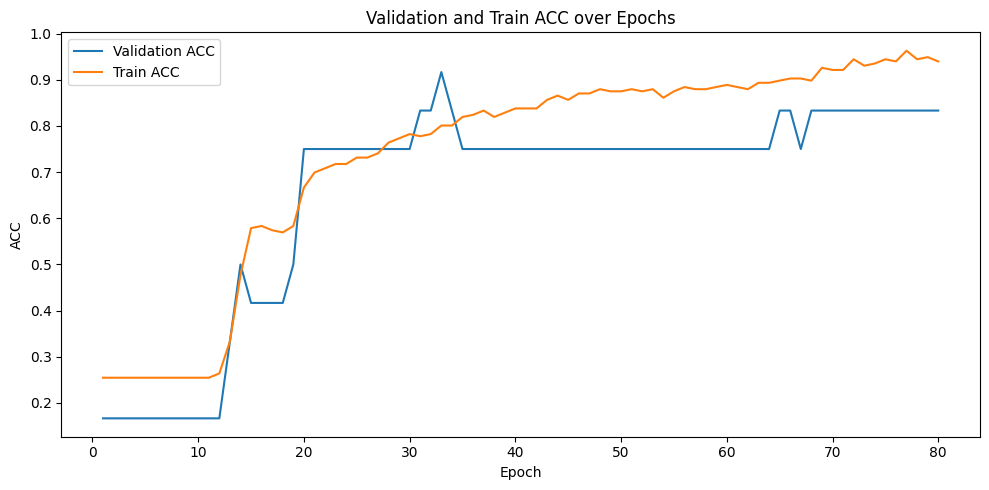

In [120]:
plt.figure(figsize=(10, 5))

plt.plot(epochs, metrics['val']['acc'][1:], label='Validation ACC')
plt.plot(epochs, metrics['train']['acc'], label='Train ACC')
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.title('Validation and Train ACC over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Test

In [84]:
trainer.test(modelDetector, data_module)

c:\Users\Cliente\Documents\Pessoal\projetos\dfki\vevn\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]


Getting metrics for moment test at epoch 0
Len logits: 3 Len labels: 3
Loss: 0.159 ACC: 1.000





┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │    0.15919731557369232    │
│      test_loss_epoch      │    0.15919731557369232    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.15919731557369232,
  'test_loss_epoch': 0.15919731557369232,
  'test_acc': 1.0}]

# 8. Test in Real Time

In [85]:
from abc import ABC, abstractmethod

class SignalDetectorABC(ABC):

    @abstractmethod
    def predict(self, frames: np.ndarray) -> np.ndarray:
        pass

In [97]:
from numpy import ndarray


class SignalDetectorKeras(SignalDetectorABC):
    def __init__(self, model: Sequential) -> None:
        super().__init__()
        self.model = model

    def predict(self, frames: np.ndarray) -> np.ndarray:
        res = self.model.predict(frames)[0]

        return res
    
class SignalDetectorPytorch(SignalDetectorABC):
    def __init__(self, model: pl.LightningModule) -> None:
        super().__init__()
        self.model = model
        self.model.eval()

    def predict(self, frames: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            loss, logits = self.model(torch.tensor(frames, dtype=torch.float32))
        return torch.nn.functional.softmax(logits, dim=1).numpy()[0]

In [98]:
signalDKeras = SignalDetectorKeras(model)
signalDetectorPytorch = SignalDetectorPytorch(modelDetector)

In [99]:
colors = [BLACK_COLOR, GREEN_COLOR, RED_COLOR, BLUE_COLOR]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_4)
        
    return output_frame

In [110]:
# 1. New detection variables
sequence = []

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks_image(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-FRAMES_TO_READ:]
        
        if len(sequence) == FRAMES_TO_READ:
            sequence_reshaped = exclude_face_landmarks(np.expand_dims(sequence, axis=0))
            res = signalDetectorPytorch.predict(sequence_reshaped)
            
            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

c:\Users\Cliente\Documents\Pessoal\projetos\dfki\vevn\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
